# Optimizing CNN's architecture using genetic algorithms

## Dataset 01: MNIST

### 01. Importing Libraries

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Dataset division: Train, test and validation

In [2]:
# Preparando os datasets e dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 4556047.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 206490.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1810607.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2153332.06it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 03. CNN Architecture

In [3]:
# Definindo a arquitetura da rede neural
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        # Camada convolucional: 1 canal de entrada (MNIST), 16 canais de saída, kernel 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Segunda camada convolucional: 16 canais de entrada, 32 de saída, kernel 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Camada totalmente conectada
        self.fc1 = nn.Linear(32 * 7 * 7, n_neurons)
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)
    
    def forward(self, x):
        # Passa pela primeira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Passa pela segunda camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Achata a saída para entrar na camada totalmente conectada
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

### 04. Training and model evalution function

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Genetic Algorithm

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [1:49:54<00:00, 1318.81s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [74, 0, 0.09422788303273114, 66]
Parâmetros: {'n_neurons': 74, 'activation_idx': 0, 'learning_rate': 0.09422788303273114, 'batch_size': 66}


### 06. Model training

#### Model 1 - Not Optimized

In [8]:
# Modelo Não Otimizado 1
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.01)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|██████▊                                                             | 1/10 [00:43<06:33, 43.76s/época]

Época 1, Loss: 2.2482



Treinamento:  20%|█████████████▌                                                      | 2/10 [01:21<05:21, 40.17s/época]

Época 2, Loss: 1.3998



Treinamento:  30%|████████████████████▍                                               | 3/10 [01:57<04:27, 38.27s/época]

Época 3, Loss: 0.6515



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [02:34<03:46, 37.73s/época]

Época 4, Loss: 0.4355



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [03:27<03:36, 43.28s/época]

Época 5, Loss: 0.3349



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [04:11<02:54, 43.51s/época]

Época 6, Loss: 0.2708



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [04:47<02:03, 41.04s/época]

Época 7, Loss: 0.2243



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [05:34<01:25, 42.86s/época]

Época 8, Loss: 0.1905



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [06:24<00:45, 45.30s/época]

Época 9, Loss: 0.1653



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.69s/época]


Época 10, Loss: 0.1463


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.98batch/s]


#### Model 2 - Not Optimized

In [9]:
# Modelo Não Otimizado 2
model_non_opt_2 = SimpleNet(n_neurons=20, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|██████▊                                                             | 1/10 [00:44<06:36, 44.04s/época]

Época 1, Loss: 0.4043



Treinamento:  20%|█████████████▌                                                      | 2/10 [01:27<05:47, 43.47s/época]

Época 2, Loss: 0.0922



Treinamento:  30%|████████████████████▍                                               | 3/10 [02:17<05:25, 46.45s/época]

Época 3, Loss: 0.0667



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [03:07<04:48, 48.04s/época]

Época 4, Loss: 0.0553



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [03:59<04:06, 49.31s/época]

Época 5, Loss: 0.0478



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [04:45<03:13, 48.28s/época]

Época 6, Loss: 0.0407



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [05:29<02:20, 46.83s/época]

Época 7, Loss: 0.0370



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [06:23<01:38, 49.09s/época]

Época 8, Loss: 0.0330



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [07:13<00:49, 49.51s/época]

Época 9, Loss: 0.0300



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [08:11<00:00, 49.17s/época]


Época 10, Loss: 0.0274


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.80batch/s]


#### Model 3 - Not Optimized

In [10]:
# Modelo Não Otimizado 3
model_non_opt_3 = SimpleNet(n_neurons=150, activation_fn=nn.Sigmoid())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.07)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_2, optimizer_3)

Treinamento:  10%|██████▊                                                             | 1/10 [00:47<07:03, 47.03s/época]

Época 1, Loss: 0.6940



Treinamento:  20%|█████████████▌                                                      | 2/10 [01:26<05:39, 42.40s/época]

Época 2, Loss: 0.1384



Treinamento:  30%|████████████████████▍                                               | 3/10 [02:10<05:02, 43.28s/época]

Época 3, Loss: 0.0902



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [03:00<04:36, 46.12s/época]

Época 4, Loss: 0.0705



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [03:49<03:55, 47.05s/época]

Época 5, Loss: 0.0584



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [04:32<03:02, 45.57s/época]

Época 6, Loss: 0.0499



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [05:10<02:08, 42.97s/época]

Época 7, Loss: 0.0432



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [05:48<01:23, 41.56s/época]

Época 8, Loss: 0.0385



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [06:26<00:40, 40.35s/época]

Época 9, Loss: 0.0338



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [07:04<00:00, 42.42s/época]


Época 10, Loss: 0.0303


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.76batch/s]


#### Model 4 - Optimized Model

In [11]:
# Modelo Otimizado
activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|██████▊                                                             | 1/10 [00:42<06:22, 42.45s/época]

Época 1, Loss: 0.2755



Treinamento:  20%|█████████████▌                                                      | 2/10 [01:21<05:22, 40.37s/época]

Época 2, Loss: 0.0633



Treinamento:  30%|████████████████████▍                                               | 3/10 [01:58<04:30, 38.68s/época]

Época 3, Loss: 0.0451



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [02:36<03:51, 38.59s/época]

Época 4, Loss: 0.0353



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [03:13<03:10, 38.04s/época]

Época 5, Loss: 0.0282



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [03:51<02:31, 37.87s/época]

Época 6, Loss: 0.0232



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [04:29<01:54, 38.07s/época]

Época 7, Loss: 0.0196



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [05:07<01:15, 37.94s/época]

Época 8, Loss: 0.0162



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [05:43<00:37, 37.28s/época]

Época 9, Loss: 0.0133



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [06:19<00:00, 38.00s/época]


Época 10, Loss: 0.0102


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.33batch/s]


### 07. Evaluating Models

In [12]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.9658, Loss = 0.1463, Tempo = 443.59s
Modelo Não Otimizado 2: Acurácia = 0.9885, Loss = 0.0274, Tempo = 496.55s
Modelo Não Otimizado 3: Acurácia = 0.9872, Loss = 0.0303, Tempo = 429.84s
Modelo Otimizado: Acurácia = 0.9894, Loss = 0.0102, Tempo = 384.45s


| Model                    | Accuracy (%) | Training Time (s) |
|--------------------------|--------------|-------------------|
| Model 1 - Non Optimized  |     96,58    |        443,59     |
| Model 2 - Non Optimized  |     98,85    |        496,55     |
| Model 3 - Non Optimized  |     98,72    |        429,84     |
| Model 4 - Optimized      |     98,94    |        384,45     |

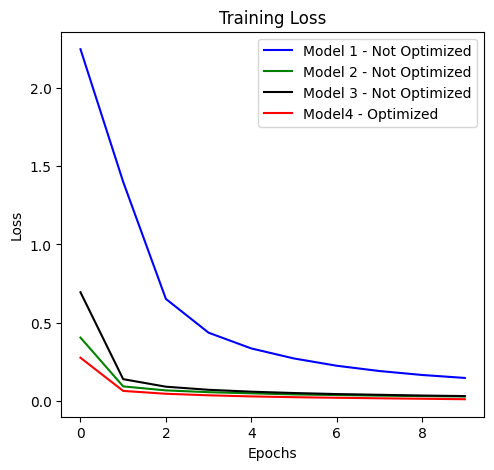

In [14]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Model 1 - Not Optimized', color='blue')
plt.plot(train_losses_non_opt_2, label='Model 2 - Not Optimized', color='green')
plt.plot(train_losses_non_opt_3, label='Model 3 - Not Optimized', color='black')
plt.plot(train_losses_opt, label='Model4 - Optimized', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

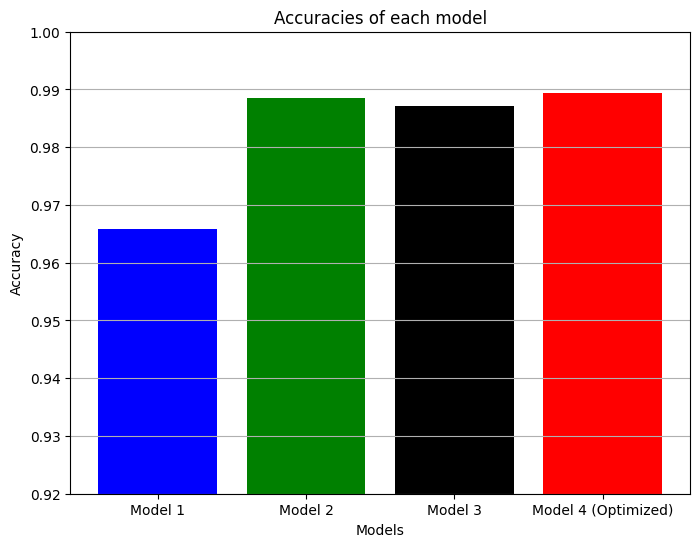

In [26]:
# Acuracias
final_accuracies = [accuracy_non_opt_1, accuracy_non_opt_2, accuracy_non_opt_3, accuracy_opt]

# Nomes dos modelos
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4 (Optimized)']

# Configuração do gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, final_accuracies, color=['blue', 'green', 'black', 'red'])
# Configurações do gráfico
plt.ylim([0.92, 1.00])  # Ajuste o limite do eixo Y para destacar as diferenças pequenas
plt.title('Accuracies of each model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')

plt.show()

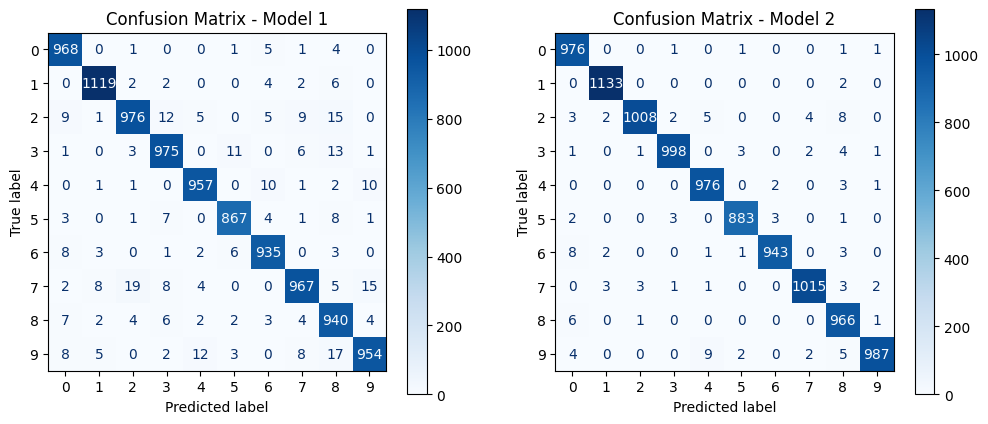

In [16]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 2')

plt.show()

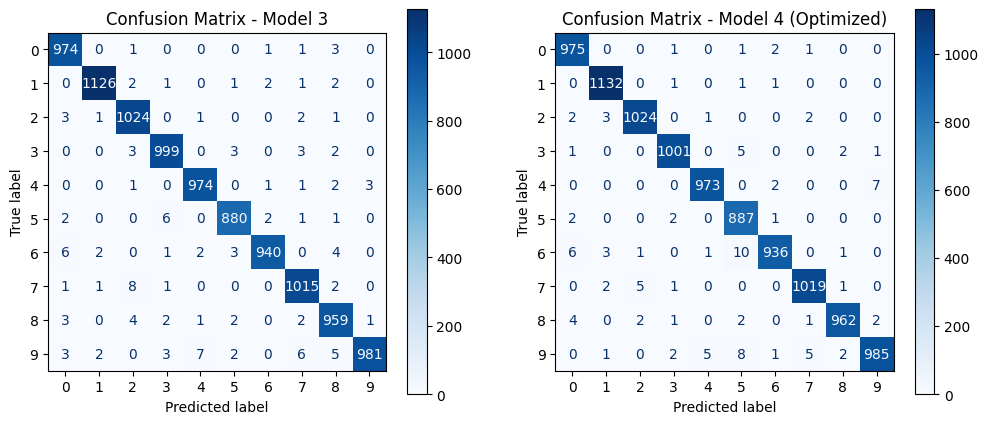

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 4 (Optimized)')

plt.show()